Prepare data

In [ ]:
from numpy import genfromtxt
import matplotlib.pyplot as plt
import numpy as np

In [2]:
oneten = genfromtxt('../data/Sadao/110nm_2.txt')

In [3]:
lo = genfromtxt('../data/Sadao/light_off.txt')

In [4]:
pbs = genfromtxt('../data/Sadao/PBS.txt')

In [38]:
lightsout = np.zeros((5000, 1, 1, 4000))
for i in range(5000):
    lightsout[i] = lo[i*4000:(i+1)*4000,1]

In [7]:
PBS = np.zeros((5000, 1, 1, 4000))
for i in range(5000):
    PBS[i] = pbs[i*4000:(i+1)*4000,1]

In [4]:
OneTen = np.zeros((5000, 1, 1, 4000))
for i in range(5000):
    OneTen[i] = oneten[i*4000:(i+1)*4000,1]

In [6]:
import tifffile
tifffile.imsave('../data/Sadao/real_observation.tif', OneTen)

/tmp/ipykernel_2878833/607881579.py:2: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave('../data/Sadao/real_observation.tif', OneTen)


In [116]:
import tifffile
tifffile.imsave('../data/Sadao/noise.tif', lightsout)
tifffile.imsave('../data/Sadao/observation.tif', PBS)

/tmp/ipykernel_903689/3132989692.py:2: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave('../data/Sadao/noise.tif', lightsout)
/tmp/ipykernel_903689/3132989692.py:3: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave('../data/Sadao/observation.tif', PBS)


Train noise model

In [1]:
import os
import torch
import numpy as np
from tifffile import imread
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
import sys
sys.path.append('../')
from noise_models.PixelCNN import PixelCNN
from utils.dataloaders import create_nm_loader
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
noise = imread('../data/Sadao/noise.tif')
noise = noise-np.mean(noise)

In [6]:
train_loader, val_loader, data_mean, data_std = create_nm_loader(noise, batch_size=32, split=0.9)

In [7]:
checkpoint_path = '../nm_checkpoint/Sadao'

In [8]:
trainer = pl.Trainer(default_root_dir=os.path.join(checkpoint_path, "PixelCNN"),
                     gpus=1 if str(device).startswith("cuda") else 0,
                     max_epochs=10000,
                     callbacks=[ModelCheckpoint(save_weights_only=False, mode="min", monitor="val_nll"),
                                LearningRateMonitor("epoch"),
                                EarlyStopping('val_nll', patience=10000)])

model = PixelCNN(kernel_size = 7,
                 depth = 5, num_filters = 128,
                 num_gaussians = 10,
                 data_mean=data_mean,
                 data_std=data_std).to(device)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [9]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name       | Type                       | Params
----------------------------------------------------------
0 | v_inconv   | VerticalStackConvolution   | 6.4 K 
1 | h_inconv   | HorizontalStackConvolution | 1.0 K 
2 | gatedconvs | ModuleList                 | 1.9 M 
3 | outconv    | Conv2d                     | 3.9 K 
----------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.716     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/rds/bear-apps/2021a/EL8-ice/software/pytorch-lightning/1.5.7-foss-2021a-CUDA-11.3.1/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/rds/bear-apps/2021a/EL8-ice/software/pytorch-lightning/1.5.7-foss-2021a-CUDA-11.3.1/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/rds/bear-apps/2021a/EL8-ice/software/pytorch-lightning/1.5.7-foss-2021a-CUDA-11.3.1/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:686: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [10]:
trainer.save_checkpoint('../nm_checkpoint/Sadao/final_params.ckpt')

Sample 2d noise model

In [52]:
import torch
from tifffile import imread, imsave
import sys
sys.path.append('../')
from noise_models.PixelCNN import PixelCNN
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [53]:
model = PixelCNN.load_from_checkpoint('../nm_checkpoint/Sadao/final_params.ckpt').to(device).eval()

In [55]:
img_shape = [1,1,1,400]
noise_sample = model.sample(img_shape=img_shape)


done: 1: 100%|████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


In [56]:
import matplotlib.pyplot as plt
import numpy as np
noise_sample = noise_sample.cpu().numpy()

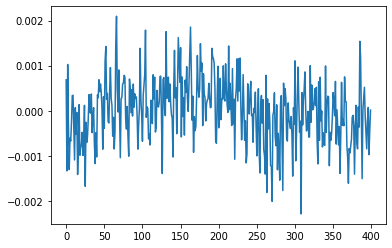

In [57]:
plt.plot(noise_sample[0,0,0])

In [58]:
import tifffile
real_noise = tifffile.imread('../data/Sadao/noise.tif')

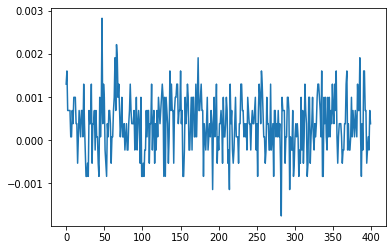

In [61]:
plt.plot(noise[2,0,0,:400])

Train VAE

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
import torch
import numpy as np
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import sys
sys.path.append('../')
from HDN.models.lvae import LadderVAE
from utils.dataloaders import create_dn_loader
from tifffile import imread
from noise_models.PixelCNN import PixelCNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import tifffile
observation = tifffile.imread('../data/Sadao/observation_cropped.tif')[:,np.newaxis]

In [14]:
train_loader, val_loader, data_mean, data_std, img_shape = create_dn_loader(observation, batch_size=8, split=0.8)

In [15]:
noiseModel = PixelCNN.load_from_checkpoint('../nm_checkpoint/Sadao/final_params.ckpt').to(device).eval()
for param in noiseModel.parameters():
    param.requires_grad = False

In [16]:
lr=3e-4
num_latents = 3
z_dims = [32]*int(num_latents)
free_bits = 0.5

model = LadderVAE(z_dims=z_dims,
                   data_mean=data_mean,
                   data_std=data_std,
                   noiseModel=noiseModel,
                   img_shape=img_shape,
                   img_folder='../dn_checkpoint/Sadao/imgs',
                   lr=lr).to(device)

checkpoint_path = '../dn_checkpoint/Sadao'
trainer = pl.Trainer(default_root_dir=os.path.join(checkpoint_path, "HDN"),
                     gpus=1 if str(device).startswith("cuda") else 0,
                     max_epochs=12000,
                     logger=False,
                     gradient_clip_val=0,
                     callbacks=[ModelCheckpoint(save_weights_only=False, mode="min", monitor="val_elbo", every_n_epochs=50),
                                EarlyStopping('val_elbo', patience=12000)])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name             | Type                 | Params
----------------------------------------------------------
0 | first_bottom_up  | Sequential           | 75.8 K
1 | top_down_layers  | ModuleList           | 2.0 M 
2 | bottom_up_layers | ModuleList           | 1.3 M 
3 | final_top_down   | Sequential           | 412 K 
4 | likelihood       | NoiseModelLikelihood | 1.9 M 
----------------------------------------------------------
3.8 M     Trainable params
1.9 M     Non-trainable params
5.7 M     Total params
22.873    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch   127: reducing learning rate of group 0 to 1.5000e-04.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch   186: reducing learning rate of group 0 to 7.5000e-05.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch   198: reducing learning rate of group 0 to 3.7500e-05.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [68]:
trainer.save_checkpoint('../dn_checkpoint/Sadao/final_params.ckpt')

In [1]:
from numpy import genfromtxt
import matplotlib.pyplot as plt
import numpy as np
from tifffile import imread
import torch
import sys
sys.path.append('../')
from HDN.models.lvae import LadderVAE
from tqdm import tqdm

In [2]:
def predict(model, observations, num_samples):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.mode_pred = True
    model.eval()
    
    num_obs = observations.shape[0]
    img_shape = (observations.shape[2], observations.shape[3])

    observations = ((observations - model.data_mean) / model.data_std).to(device)
    
    samples = torch.zeros((num_obs,num_samples,img_shape[0],img_shape[1]))

    for i in tqdm(range(num_obs)):
        for j in range(num_samples):
            samples[i, j] = model(observations[i:i+1])['out_mean'].detach()
        
    samples = (samples.cpu() * model.data_std + model.data_mean).numpy()
    
    mmse = np.mean(samples, axis=1, keepdims=True)
    
    observations = observations * model.data_std + model.data_mean
    
    return mmse, samples

In [3]:
model = LadderVAE.load_from_checkpoint('../dn_checkpoint/Sadao/HDN/checkpoints/epoch=249-step=28499.ckpt').to(torch.device('cuda'))

In [4]:
observation2 = imread('../data/Sadao/observation_cropped2.tif')[:,np.newaxis]

In [68]:
observation2.shape

(1149, 1, 700)

In [41]:
mmse, samples = predict(model, torch.from_numpy(observation2[294:295,np.newaxis]).type(torch.float).to(torch.device('cuda')), 100)

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.07s/it]


In [36]:
mmse_low, samples_low = predict(model, torch.from_numpy(observation2[294:295,np.newaxis]).type(torch.float).to(torch.device('cuda')), 1000)

100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.69s/it]


In [ ]:
import matplotlib.pyplot as plt
plt.plot(observation[0,0])
plt.plot(mmse[0,0,0])
plt.plot(samples[0,0,0])
plt.xlim(150,250)
plt.show()
plt.plot(observation[1,0])
plt.plot(mmse[1,0,0])
plt.plot(samples[1,0,0])
plt.xlim(150,250)
plt.show()
plt.plot(observation[2,0])
plt.plot(mmse[2,0,0])
plt.plot(samples[2,0,0])
plt.xlim(150,250)
plt.show()
plt.plot(observation[3,0])
plt.plot(mmse[3,0,0])
plt.plot(samples[3,0,0])
plt.xlim(150,250)
plt.show()
plt.plot(observation[4,0], label='observation')
plt.plot(mmse[4,0,0], label='mmse')
plt.plot(samples[4,0,0], label='sample')
plt.xlim(150,250)
plt.legend()
plt.show()

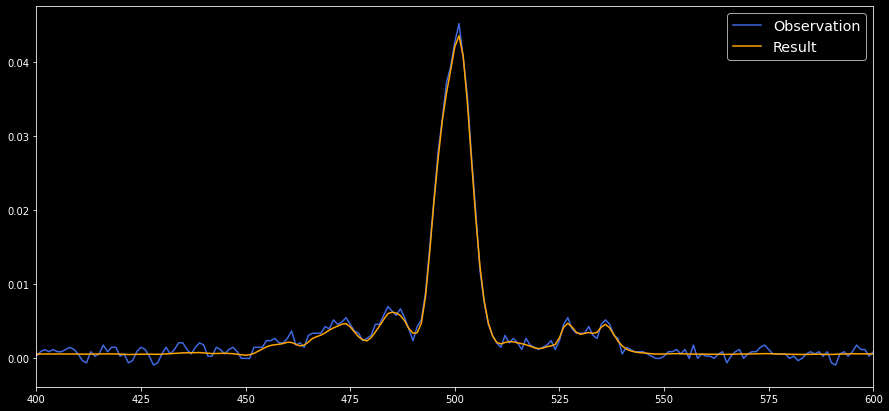

In [43]:
import matplotlib.pyplot as plt

with plt.style.context('dark_background'):
    plt.figure(figsize=[15,7])
    plt.plot(observation2[294,0], label='Observation', color='royalblue')
    plt.plot(mmse[0,0,0], label='Result', color='orange')
    #plt.plot(samples[0,0,0])
    plt.xlim(400,600)
    plt.legend(fontsize='x-large')
    plt.show()

(100.0, 300.0)

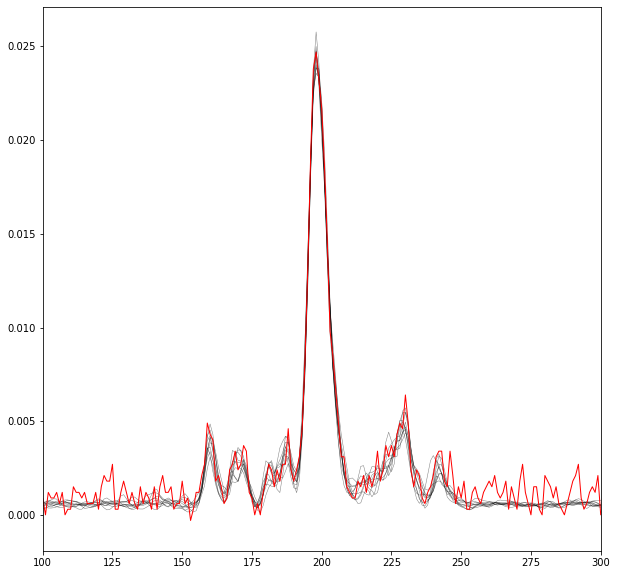

In [49]:
idx = 2
plt.figure(figsize=[10,10])
for i in range(10):
    plt.plot(samples[idx,i,0], color='black', lw=0.5, alpha=0.5)
plt.plot(observation[idx,0], color='red', lw=1)
plt.xlim(100,300)

(150.0, 300.0)

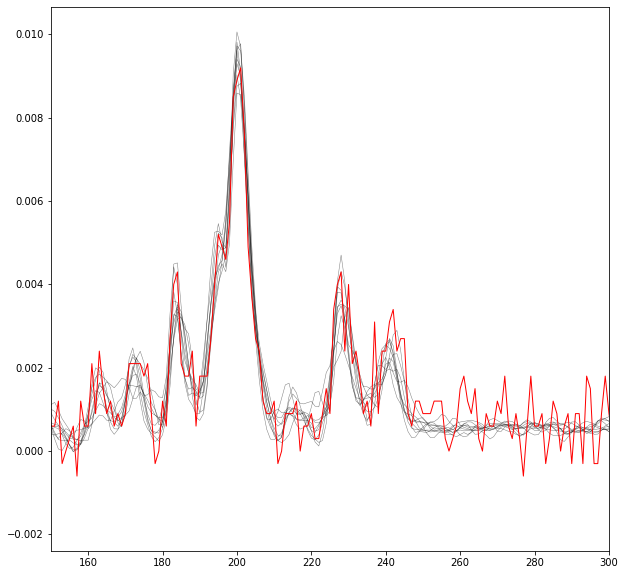

In [53]:
idx = 0
plt.figure(figsize=[10,10])
for i in range(10):
    plt.plot(samples_low[idx,i,0], color='black', lw=0.5, alpha=0.5)
plt.plot(observation[295,0], color='red', lw=1)
plt.xlim(150,300)

In [87]:
np.where(np.max(observation, axis=-1)<0.01)

(array([295, 587, 945]), array([0, 0, 0]))

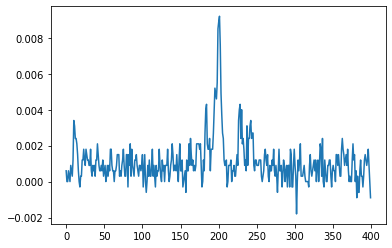

In [88]:
plt.plot(observation[295,0])

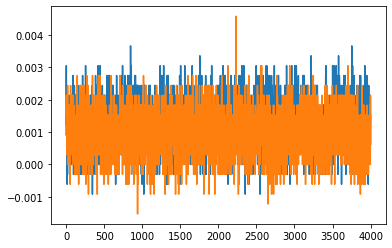

In [9]:
import matplotlib.pyplot as plt
import tifffile
real_noise = tifffile.imread('../data/Sadao/noise.tif')
observation = tifffile.imread('../data/Sadao/observation.tif')
#plt.plot(real_noise[0,0,0])


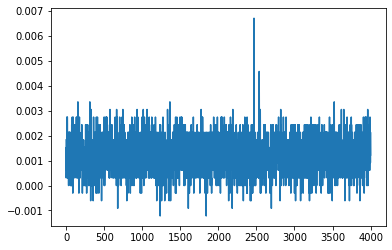

In [26]:
plt.plot(noise[1337,0,0])

In [25]:
np.where(noise >0.006)

(array([1337, 2094, 3998, 4504]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([2468, 3358, 2276, 2114]))

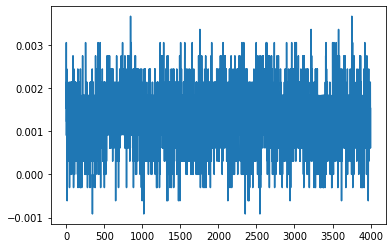

In [24]:
plt.plot(real_noise[0,0,0])

Train HDN gaussian

In [23]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import torch
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import sys
sys.path.append('../')
from HDN.models.lvae import LadderVAE
from utils.dataloaders import create_dn_loader
from tifffile import imread

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

observation = imread('../data/Sadao/observation_cropped.tif')[:,np.newaxis]
noise = imread('../data/Sadao/noise.tif')

train_loader, val_loader, data_mean, data_std, img_shape = create_dn_loader(observation, batch_size=16, split=0.9)

gaussian_noise_std = np.std(noise)

In [26]:
lr=3e-4
num_latents = 3
z_dims = [32]*int(num_latents)
free_bits = 0.5

model = LadderVAE(z_dims=z_dims,
                  data_mean=data_mean,
                  data_std=data_std,
                  gaussian_noise_std=gaussian_noise_std,
                  img_shape=img_shape,
                  img_folder='../dn_checkpoint/Sadao/gaussian/imgs',
                  lr=lr)

checkpoint_path = '../dn_checkpoint/Sadao/gaussian'
trainer = pl.Trainer(default_root_dir=os.path.join(checkpoint_path, "HDN"),
                     gpus=1 if str(device).startswith("cuda") else 0,
                     max_epochs=6000,
                     logger=False,
                     gradient_clip_val=0,
                     callbacks=[ModelCheckpoint(save_weights_only=False, mode="min", monitor="val_elbo", every_n_epochs=50),
                                EarlyStopping('val_elbo', patience=6000)])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [27]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name             | Type               | Params
--------------------------------------------------------
0 | first_bottom_up  | Sequential         | 75.8 K
1 | top_down_layers  | ModuleList         | 2.0 M 
2 | bottom_up_layers | ModuleList         | 1.3 M 
3 | final_top_down   | Sequential         | 412 K 
4 | likelihood       | GaussianLikelihood | 577   
--------------------------------------------------------
3.8 M     Trainable params
0         Non-trainable params
3.8 M     Total params
15.156    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [28]:
trainer.save_checkpoint('../dn_checkpoint/Sadao/gaussian/final_params.ckpt')

In [29]:
from numpy import genfromtxt
import matplotlib.pyplot as plt
import numpy as np
from tifffile import imread
import torch
import sys
sys.path.append('../')
from HDN.models.lvae import LadderVAE
from tqdm import tqdm

In [30]:
def predict(model, observations, num_samples):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.mode_pred = True
    model.eval()
    
    num_obs = observations.shape[0]
    img_shape = (observations.shape[2], observations.shape[3])

    observations = ((observations - model.data_mean) / model.data_std).to(device)
    
    samples = torch.zeros((num_obs,num_samples,img_shape[0],img_shape[1]))

    for i in tqdm(range(num_obs)):
        for j in range(num_samples):
            samples[i, j] = model(observations[i:i+1])['out_mean'].detach()
        
    samples = (samples.cpu() * model.data_std + model.data_mean).numpy()
    
    mmse = np.mean(samples, axis=1, keepdims=True)
    
    observations = observations * model.data_std + model.data_mean
    
    return mmse, samples

In [31]:
model = LadderVAE.load_from_checkpoint('../dn_checkpoint/Sadao/gaussian/final_params.ckpt').to(torch.device('cuda'))

In [32]:
mmse, samples = predict(model, torch.from_numpy(observation[:5,np.newaxis]).type(torch.float).to(torch.device('cuda')), 100)


100%|█████████████████████████████████████████████| 5/5 [00:11<00:00,  2.34s/it]


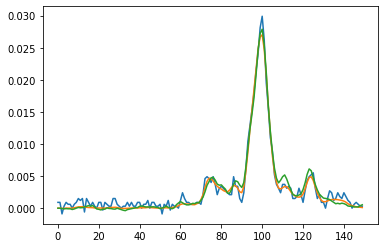

In [43]:
import matplotlib.pyplot as plt
plt.plot(observation[1,0,100:250])
plt.plot(mmse[1,0,0,100:250])
plt.plot(samples[1,0,0,100:250])

In [40]:
np.where(np.max(observation, axis=-1) < 0.01)

(array([295, 587, 945]), array([0, 0, 0]))